# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 30 ноября 2021, 08:30 

**Максимально баллов:** 10 

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
#from sklearn.datasets import fetch_mldata, fetch_20newsgroups # у вас тут какое-то старье https://github.com/ageron/handson-ml/issues/529
from sklearn.datasets import fetch_openml, fetch_20newsgroups


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
from scipy.stats import mode
from scipy import stats


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm        
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X_train = X
            self.y_train = y
            self.X_train = np.float64(X)
            self.classes, self.y_train = np.unique(y, return_inverse=True)
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
            self.y_train = y
        elif self.algorithm == 'kd_tree_spacial':
            self.tree = scipy.spatial.KDTree(X, balanced_tree = False)

    def euclidean_distance(self, data1, data2):
        return np.sqrt(np.sum((data1-data2)**2))
    
    #def cos_distance(self, data1, data2):
    #    return distance.cosine(data1, data2)
    
    def kneighbors(self, X):
        if self.algorithm == 'brute':
            neighbors = pairwise_distances(X=X, Y=self.X_train)
            k_ind = neighbors.argpartition(self.n_neighbors)
            k_ind = k_ind[:, :self.n_neighbors]
            k_dist = neighbors[:, k_ind]
        elif self.algorithm == 'kd_tree':
            k_dist, k_ind = self.tree.query(X, k=self.n_neighbors)
        return k_dist, k_ind

    def predict(self, X):
        X = X.astype(float)
        k_dist, k_ind = self.kneighbors(X)
        n_samples = X.shape[0]
        y_pred = np.zeros(X.shape[0], dtype=int)
        for idx, k in enumerate(k_ind):
            mode, _ = stats.mode(self.y_train[np.array(k)])
            y_pred[idx] = mode[0]
        return y_pred
              
        
    def score(self, X, y):
        Y = self.predict(X)
        return np.mean(y == Y)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

/Users/olgageta/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/var/folders/rs/fkk70l394gz79cxj0sdr_spc0000gn/T/ipykernel_10265/3579281740.py:41: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted.

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 644 µs, sys: 388 µs, total: 1.03 ms
Wall time: 673 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 206 µs, sys: 78 µs, total: 284 µs
Wall time: 198 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 1.78 ms, sys: 915 µs, total: 2.7 ms
Wall time: 1.84 ms


/Users/olgageta/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 2.21 ms, sys: 888 µs, total: 3.1 ms
Wall time: 2.43 ms


/var/folders/rs/fkk70l394gz79cxj0sdr_spc0000gn/T/ipykernel_10265/3579281740.py:41: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(self.y_train[np.array(k)])


array([0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 662 µs, sys: 138 µs, total: 800 µs
Wall time: 753 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 318 µs, sys: 47 µs, total: 365 µs
Wall time: 473 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 2.34 ms, sys: 1.21 ms, total: 3.56 ms
Wall time: 2.7 ms


/Users/olgageta/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 2, 0, 2])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 2.57 ms, sys: 1.19 ms, total: 3.77 ms
Wall time: 2.99 ms


/var/folders/rs/fkk70l394gz79cxj0sdr_spc0000gn/T/ipykernel_10265/3579281740.py:41: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(self.y_train[np.array(k)])


array([2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 2, 2, 0, 2])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

/Users/olgageta/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/var/folders/rs/fkk70l394gz79cxj0sdr_spc0000gn/T/ipykernel_10265/3579281740.py:41: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted.

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(data).toarray()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
#my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree_spacial')
#my_clf.fit(X_vec, target)

#cv_results = cross_validate(my_clf, X_vec, target, cv=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
#def 

'''
Тут была функция для создания метода, но у меня не получилось и я удалила шаблон, извините



'''

'\nТут была функция для создания метода, но у меня не получилось и я удалила шаблон, извините\n\n\n\n'

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [24]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

# Линейные модели (5 баллов)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. 

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [37]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    storage = np.concatenate((X, y[:, None]), axis=1)
    
    if shuffle:
        np.random.shuffle(storage)
    for i in np.vsplit(storage[:(storage.shape[0]//batch_size*batch_size)], storage.shape[0]//batch_size):
        yield (i[:, :-1], i[:, -1].flatten())
        
    else: 
        shuffled_y = y
        shuffled_x = X

In [38]:
 
# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [39]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    return 1 / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        a = np.dot(X_batch, self.weights)
        if self.model_type == 'lin_reg':
            buf = (y_batch - a)
            loss = 1/X_batch.shape[0] * np.dot(buf,buf)
        elif self.model_type == 'log_reg':
            a = sigmoid(a)
            buf = y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)
            loss = -1 / X_batch.shape[0] * np.sum(buf)
        return loss + 1 / self.C * np.dot(self.weights, self.weights)
       
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if self.model_type == 'lin_reg':
            buf = (np.dot(X_batch, self.weights) - y_batch)[:, None]
            buf = buf * X_batch
            loss_grad = 2 / X_batch.shape[0] * np.sum(buf, axis = 0)
        elif self.model_type == 'log_reg':
            buf = (sigmoid(np.dot(X_batch, self.weights)) - y_batch)[:, None]
            buf = buf * X_batch
            loss_grad = 1 / X_batch.shape[0] * \
                    np.sum(buf, axis = 0)
        r = 2 / self.C * self.weights
        r[0] = 0
        return loss_grad + r 
        
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        
        self.weights = self.weights - self.alpha * new_grad       
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализровать случайно веса
        #self.weights = np.random.randn(X.shape[1] 
        #for n in range(0, self.max_epoch):                          
         #   new_epoch_generator = self.batch_generator()
                                       
        #for batch_num, new_batch in enumerate(new_epoch_generator):
        self.weights = np.random.rand(X.shape[1] + 1)
        for n in tqdm(range(0, self.max_epoch)):
            buf = np.hstack((np.ones((X.shape[0], 1)), X))
            new_epoch_generator = self.batch_generator(buf, y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]

                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                self.update_weights(batch_grad)       
            #X_batch = new_batch[0]
            #y_batch = new_batch[1]
            #batch_grad = self.calc_loss_grad(X_batch, y_batch)
            #self.update_weights(batch_grad)
            #batch_loss = self.calc_loss(X_batch, y_batch)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                # batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights[1::])
        return (y_hat > 0).astype(int)
        if self.model_type == 'log_reg':
            buf = np.hstack((np.ones((X.shape[0], 1)), X))
            y_hat = np.dot(buf, self.weights)
            #return (sigmoid(y_hat) > 0.5).astype(int)
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [40]:
def plot_decision_boundary(clf):
    x = np.linspace(-4, 8, 100)
    y = -clf.weights[1] / clf.weights[2] * x - \
        clf.weights[0] / clf.weights[2]
    plt.plot(x, y)
    ## Your code Here

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.99it/s]


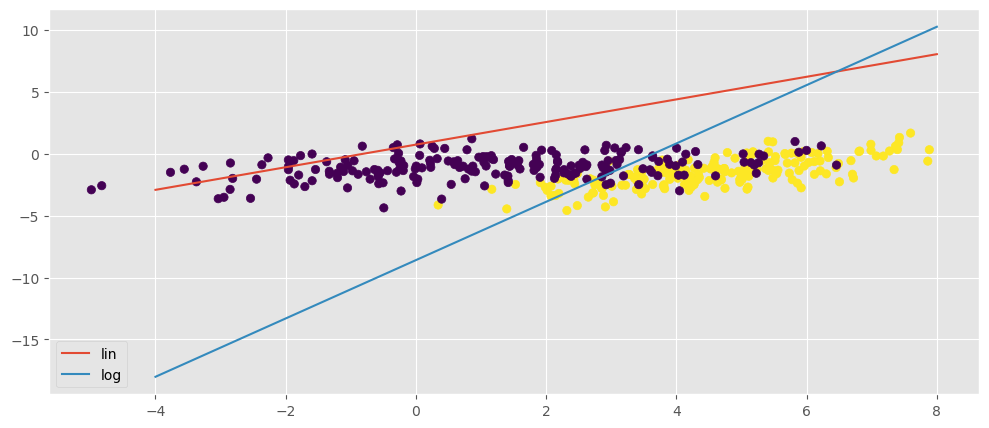

In [41]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

your_model = MySGDClassifier(batch_generator,
                             max_epoch=10,
                             model_type='lin_reg',
                             alpha=0.01, C=1)
your_model.fit(X, y)
plot_decision_boundary(your_model)
your_model = MySGDClassifier(batch_generator,
                             max_epoch=10,
                             model_type='log_reg',
                             alpha=0.01,
                             C=1)
your_model.fit(X, y)
plot_decision_boundary(your_model)
plt.legend(['lin', 'log'], loc='lower left')

# plot_decision_boundary(your_model)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [42]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]

200000
(200, 1000)


ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

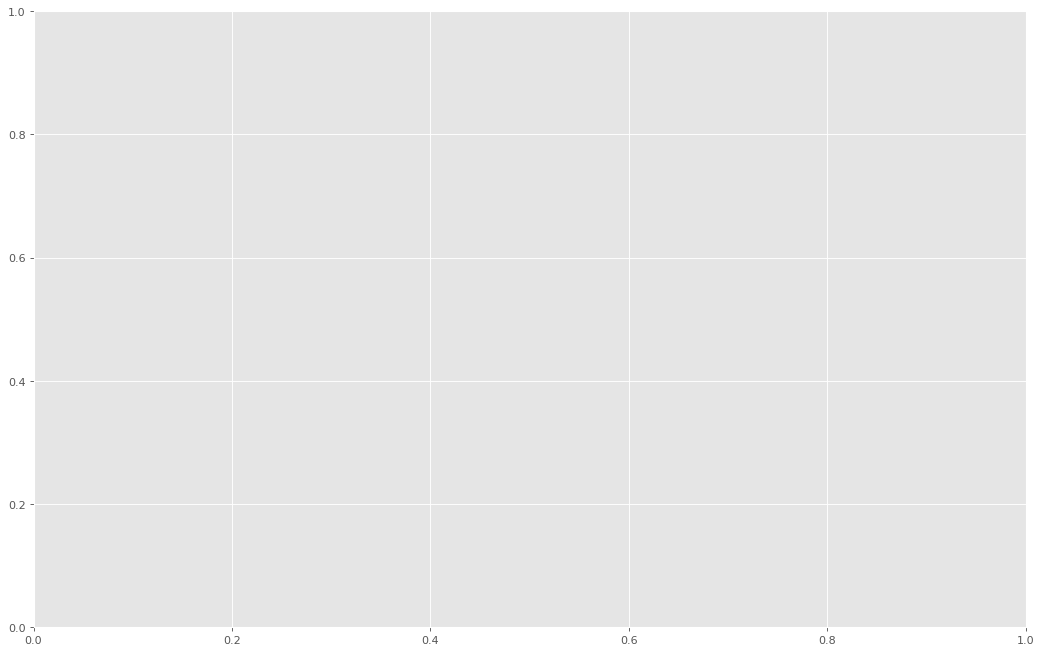

In [43]:
## Your Code Here
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
N = 1000
for a in [0.001, 0.01, 0.03]:
    myclf = MySGDClassifier(batch_generator, max_epoch=1, alpha=a)
    myclf.fit(X, y)
    print(len(myclf.errors_log['loss']))
    buf = np.reshape(myclf.errors_log['loss'], (-1, N))
    print(buf.shape)
    buf = np.mean(buf, axis=1).flatten()

    plt.plot(range(X.shape[0] // N), buf)
plt.legend(['0.001', '0.01', '0.03'], loc='lower left')

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

[1.00000000e+03 2.15443469e+02 4.64158883e+01 1.00000000e+01
 2.15443469e+00 4.64158883e-01 1.00000000e-01 2.15443469e-02
 4.64158883e-03 1.00000000e-03]


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]

[0.034196005034504734, 0.03439174017476068, 0.03479615970555452, 0.035919066566769034, 0.038134922441039006, 0.04003069487275978, 0.04255514181436846, 0.044559393945623686, 0.0453142282488163, 0.045472688598483905]


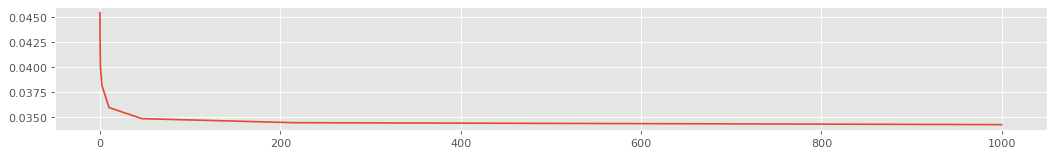

In [44]:
## Your Code Here
plt.figure(num=None, figsize=(16, 2), dpi=80, facecolor='w', edgecolor='k')
print(np.logspace(3, -3, 10))
w = []
for i in np.logspace(3, -3, 10):
    myclf = MySGDClassifier(batch_generator,
                            C=i,
                            alpha=0.00001,
                            max_epoch=10,
                            model_type='lin_reg')
    myclf.fit(X.astype('float64'), y.astype('float64'))
    w.append(np.mean(myclf.weights))
print(w)
plt.plot(np.logspace(3, -3, 10), w)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 